## Importing Necessary Libraries  
We import the required libraries for data manipulation, network analysis, and visualization:  
- `pandas` for handling tabular data  
- `networkx` for graph analysis  
- `matplotlib` and `seaborn` for visualization  

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the Data  
We load the dataset containing city information (`cities_data.csv`) and trip connections (`trips_data.csv`) using `pandas`.  

In [2]:
cities_df = pd.read_csv('data/cities_data.csv')
trips_df = pd.read_csv('data/trips_data.csv')

## Previewing the Data  
We display the first few rows of both datasets to understand their structure and contents.  

In [3]:
cities_df.head()

,city,city_href,country,country_href
0,Durrës,/bus/durres,Albania,/bus/albania
1,Elbasan,/bus/elbasan,Albania,/bus/albania
2,Fier,/bus/fier,Albania,/bus/albania
3,Kavajë,/bus/kavaje,Albania,/bus/albania
4,Lezhe,/bus/lezhe,Albania,/bus/albania


In [4]:
trips_df.head()

,from,to,trip_href
0,Podgorica,Durrës,/bus-routes/bus-podgorica-durres
1,Budva,Durrës,/bus-routes/bus-budva-durres
2,Ohrid,Durrës,/bus-routes/bus-ohrid-durres
3,Durrës,Budva,/bus-routes/bus-durres-budva
4,Durrës,Dubrovnik,/bus-routes/bus-durres-dubrovnik


## Merging and Filtering Data for European Trips  
- We **merge** the `trips_df` dataset with `cities_df` to get **country information** for both origin (`from`) and destination (`to`) cities.  
- A **list of European countries** is defined to filter trips where **both origin and destination** are within Europe.  

In [5]:
# Merge to get country information for both 'from' and 'to' cities
merged_df = trips_df.merge(
    cities_df.rename(columns={'city': 'from', 'country': 'from_country', 'country_href': 'from_country_href'}),
    on='from',
    how='left'
).merge(
    cities_df.rename(columns={'city': 'to', 'country': 'to_country', 'country_href': 'to_country_href'}),
    on='to',
    how='left'
)

# List of European countries
european_countries = [
    'Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina',
    'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia',
    'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland',
    'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg',
    'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia',
    'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino',
    'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
    'Turkey', 'Ukraine', 'United Kingdom', 'Vatican City'
]

# Filter for trips where both origin and destination are in European countries
european_trips = merged_df[
    merged_df['from_country'].isin(european_countries) & 
    merged_df['to_country'].isin(european_countries)
]

## Cleaning the European Trips Data  
- We **preview** the filtered European trips dataset.  
- Unnecessary columns (`trip_href`, `city_href_x`, `from_country_href`, `city_href_y`, `to_country_href`) are **removed** to keep only relevant information.  
- The cleaned dataset is displayed again for verification.  

In [6]:
european_trips.head()

,from,to,trip_href,city_href_x,from_country,from_country_href,city_href_y,to_country,to_country_href
0,Podgorica,Durrës,/bus-routes/bus-podgorica-durres,/bus/podgorica,Montenegro,/bus/montenegro,/bus/durres,Albania,/bus/albania
1,Budva,Durrës,/bus-routes/bus-budva-durres,/bus/budva,Montenegro,/bus/montenegro,/bus/durres,Albania,/bus/albania
3,Durrës,Budva,/bus-routes/bus-durres-budva,/bus/durres,Albania,/bus/albania,/bus/budva,Montenegro,/bus/montenegro
4,Durrës,Dubrovnik,/bus-routes/bus-durres-dubrovnik,/bus/durres,Albania,/bus/albania,/bus/dubrovnik,Croatia,/bus/croatia
6,Kotor,Durrës,/bus-routes/bus-kotor-durres,/bus/kotor,Montenegro,/bus/montenegro,/bus/durres,Albania,/bus/albania


In [7]:
european_trips = european_trips.drop(['trip_href', 'city_href_x', 'from_country_href', 'city_href_y', 'to_country_href'], axis=1)
european_trips.head()

,from,to,from_country,to_country
0,Podgorica,Durrës,Montenegro,Albania
1,Budva,Durrës,Montenegro,Albania
3,Durrës,Budva,Albania,Montenegro
4,Durrës,Dubrovnik,Albania,Croatia
6,Kotor,Durrës,Montenegro,Albania


## Creating a Unique Trip Identifier  
A new column **`trip`** is created by concatenating the origin (`from`) and destination (`to`) city names with a hyphen (`-`). This helps in uniquely identifying each trip.  

In [8]:
european_trips['trip'] = european_trips['from'] + '-' + european_trips['to']
european_trips.head()

,from,to,from_country,to_country,trip
0,Podgorica,Durrës,Montenegro,Albania,Podgorica-Durrës
1,Budva,Durrës,Montenegro,Albania,Budva-Durrës
3,Durrës,Budva,Albania,Montenegro,Durrës-Budva
4,Durrës,Dubrovnik,Albania,Croatia,Durrës-Dubrovnik
6,Kotor,Durrës,Montenegro,Albania,Kotor-Durrës


In [ ]:

from collections import Counter

## Creating a Directed Graph  
We construct a **directed graph** (`DiGraph`) using **NetworkX**, where:  
- Nodes represent **cities**  
- Directed edges represent **trips** between cities  
- The **trip column** is used as an edge attribute  

In [9]:
G = nx.from_pandas_edgelist(
    european_trips,
    source='from',
    target='to',
    edge_attr='trip',
    create_using=nx.DiGraph()
)

## Calculating and Visualizing Degree Centrality  
- **Degree centrality** is computed to measure the influence of each city in the network.  
- The results are stored in a DataFrame and sorted in descending order.  
- The **top 50 cities** with the highest degree centrality are selected and visualized using a bar chart.  

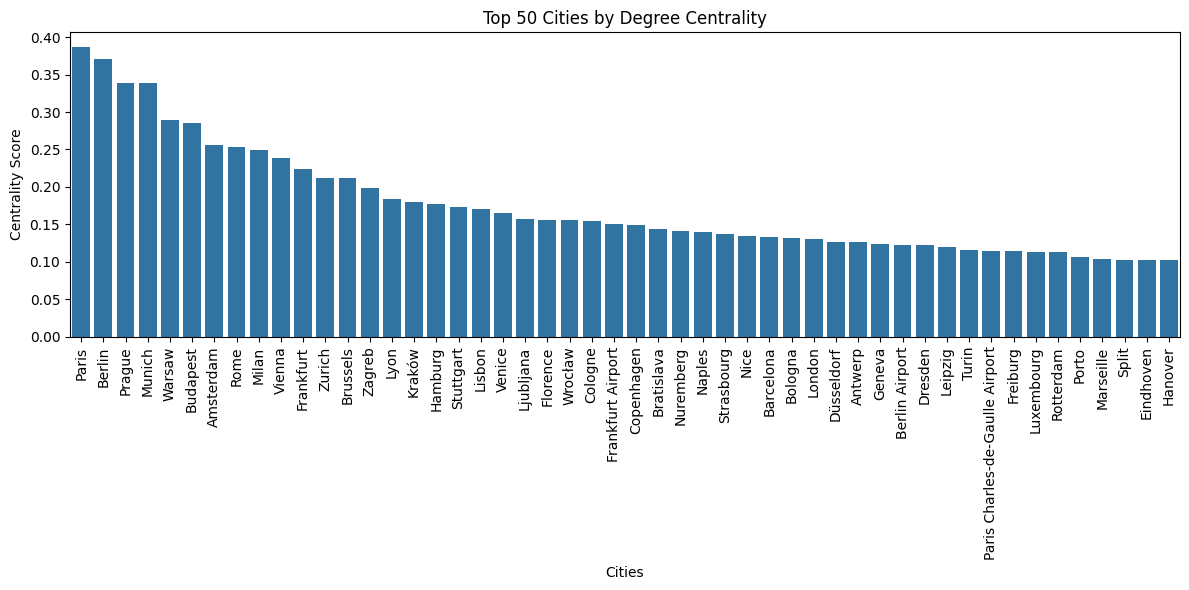

In [10]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Convert to dataframe and sort
degree_df = pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['centrality'])
degree_df = degree_df.sort_values('centrality', ascending=False)

# Select the top 30 nodes
top_degree_df = degree_df.head(50)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_degree_df.index, y='centrality', data=top_degree_df)
plt.title('Top 50 Cities by Degree Centrality')
plt.xticks(rotation=90)
plt.ylabel('Centrality Score')
plt.xlabel('Cities')
plt.tight_layout()
plt.show()

## Calculating and Visualizing Betweenness Centrality  
- **Betweenness centrality** is computed to identify cities that act as key intermediaries in the network.  
- The results are stored in a DataFrame and sorted in descending order.  
- The **top 50 cities** with the highest betweenness centrality are selected and visualized using a bar chart.  

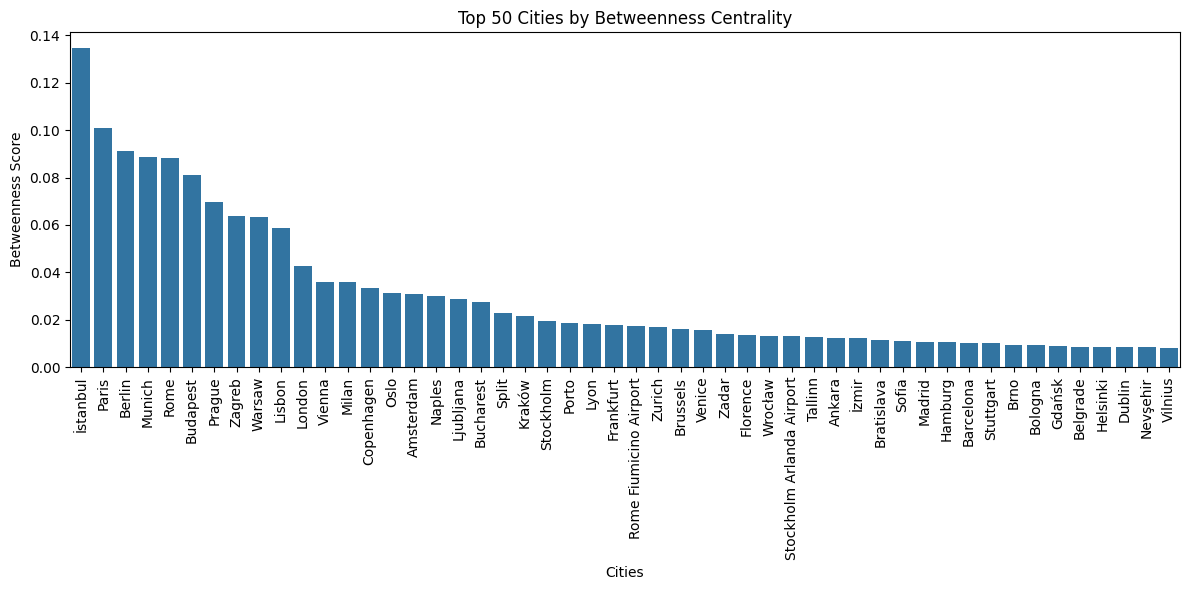

In [11]:
# Calculate betweenness centrality
betweenness = nx.betweenness_centrality(G)

# Convert to dataframe and sort
betweenness_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness'])
betweenness_df = betweenness_df.sort_values('betweenness', ascending=False)

# Select the top 50 nodes
top_betweenness_df = betweenness_df.head(50)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_betweenness_df.index, y='betweenness', data=top_betweenness_df)
plt.title('Top 50 Cities by Betweenness Centrality')
plt.xticks(rotation=90)
plt.ylabel('Betweenness Score')
plt.xlabel('Cities')
plt.tight_layout()
plt.show()

## Visualizing the Top 20 Most Connected Cities  
- The **top 20 cities** with the highest degree centrality are selected.  
- A **subgraph** is created using these cities and displayed with a **spring layout** for better visualization.  
- **Node size** and **color** are adjusted for clarity, and **edges** are drawn with arrows to indicate direction.  

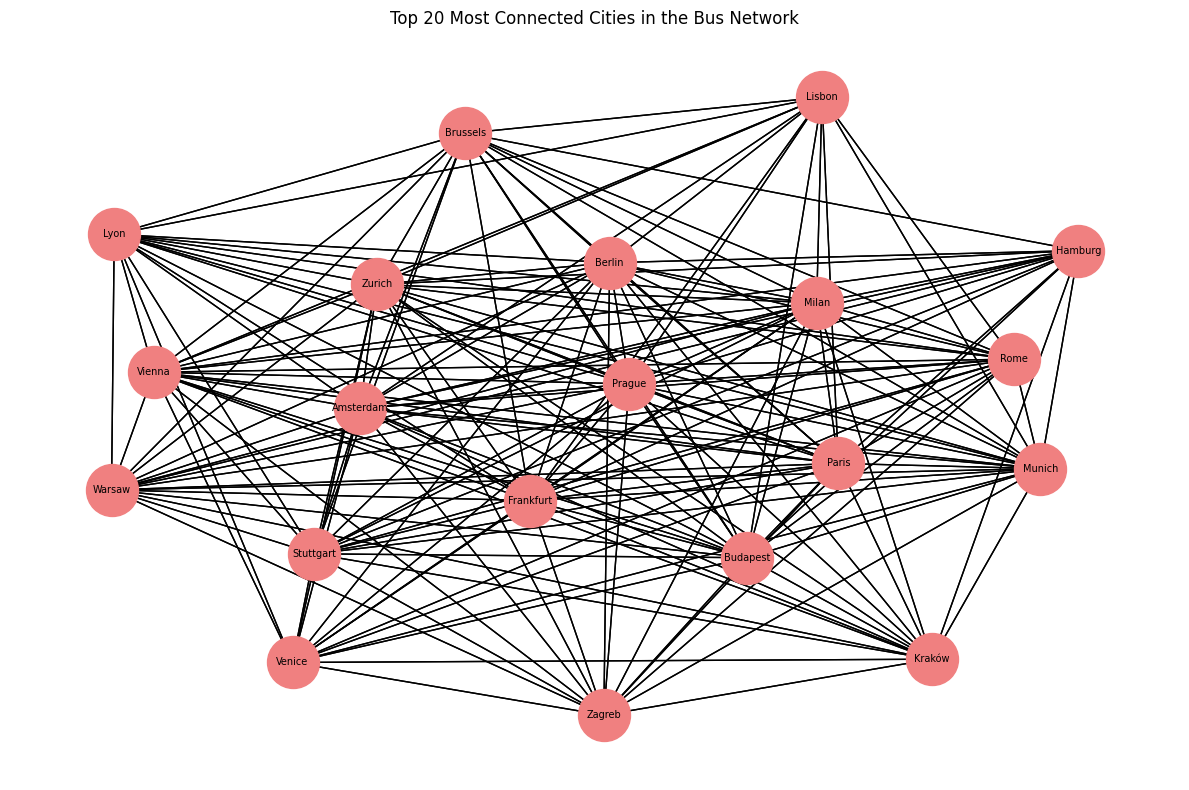

In [12]:
top_nodes = sorted(nx.degree_centrality(G), key=nx.degree_centrality(G).get, reverse=True)[:20]
subgraph = G.subgraph(top_nodes)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=1400, node_color='lightcoral')
nx.draw_networkx_edges(subgraph, pos, arrowstyle='->', arrowsize=15)
nx.draw_networkx_labels(subgraph, pos, font_size=7)

plt.title('Top 20 Most Connected Cities in the Bus Network')
plt.axis('off')
plt.tight_layout()
plt.show()

## Visualizing the Most Connected Origin Countries  
- We count the connections between countries by grouping the data based on **origin** and **destination countries**.  
- The **top 3 most connected origin countries** are selected, and the data is filtered accordingly.  
- A **bar plot** is created to visualize the number of routes from each origin country, with a horizontal legend placed inside the plot (top-right corner).  

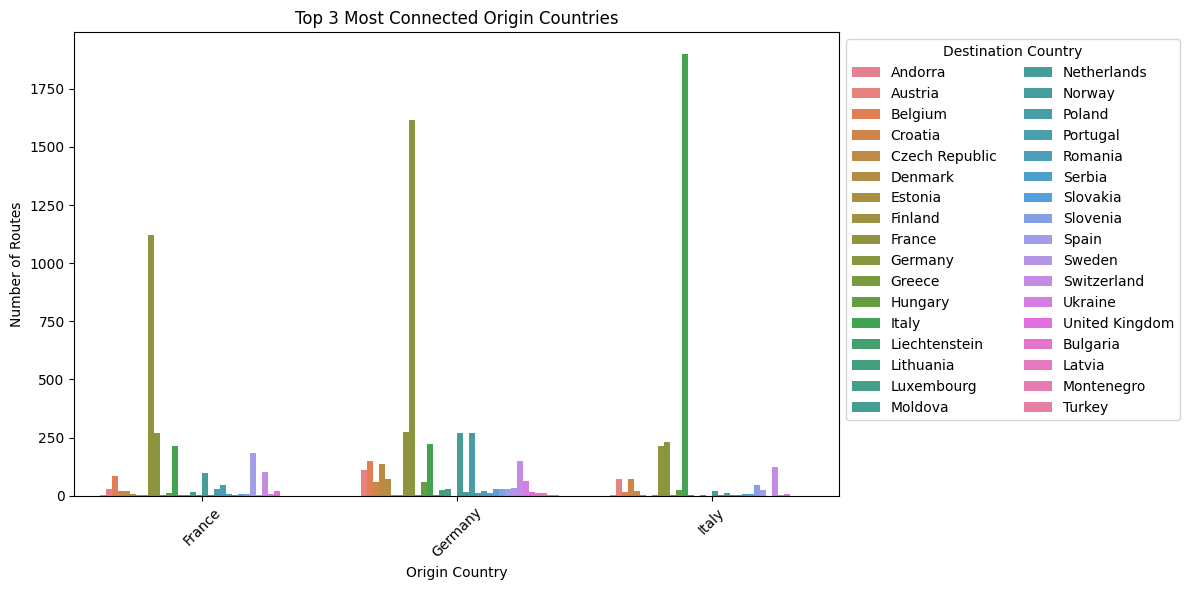

In [13]:
# Count connections between countries
country_connections = european_trips.groupby(['from_country', 'to_country']).size().reset_index(name='count')

# Get top 3 most connected origin countries
top_countries = country_connections.groupby('from_country')['count'].sum().nlargest(3).index
filtered_df = country_connections[country_connections['from_country'].isin(top_countries)]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='from_country', y='count', data=filtered_df, hue='to_country')

plt.title('Top 3 Most Connected Origin Countries')
plt.xlabel('Origin Country')
plt.ylabel('Number of Routes')
plt.xticks(rotation=45)

# Make legend horizontal and inside the plot (top-right)
plt.legend(title='Destination Country', bbox_to_anchor=(1, 1), loc='upper left', ncol=2, frameon=True)

plt.tight_layout()
plt.show()


## Identifying Bidirectional Routes  
- We check for **bidirectional routes** in the dataset, where a route from city A to city B also exists from city B to city A.  
- **Duplicate routes** are removed to ensure each bidirectional connection is listed only once.  
- The total number of bidirectional routes is displayed, along with the list of these routes.  

In [14]:
# Check for bidirectional routes
bidirectional = []
for _, row in european_trips.iterrows():
    reverse_route = european_trips[(european_trips['from'] == row['to']) & (european_trips['to'] == row['from'])]
    if not reverse_route.empty:
        bidirectional.append((row['from'], row['to']))

# Remove duplicates
bidirectional = list(set(tuple(sorted(pair)) for pair in bidirectional))

print(f"Bidirectional routes found: {len(bidirectional)}")
for route in bidirectional:
    print(f"{route[0]} ↔ {route[1]}")

Bidirectional routes found: 9256
Copenhagen ↔ Hamburg
Brussels ↔ Timișoara
Antwerp ↔ Utrecht
Berlin ↔ Moss
Marburg ↔ Munich
Bremen ↔ Dijon
Magdeburg ↔ Prague
Lyon ↔ Mulhouse
Faro ↔ Seville
Lviv ↔ Vilnius
Dortmund ↔ Roermond
Brașov ↔ Kraków
Heidelberg ↔ Toulouse
Borås ↔ Jönköping
Lamezia Terme ↔ Lamezia Terme Airport
Kamienna Góra ↔ Prague
Chemnitz ↔ Munich
Hof ↔ Munich
Belgrade ↔ Trieste
Nijmegen ↔ Nuremberg
Meran (Merano) ↔ Munich
Bragança ↔ Francisco Sá Carneiro Airport
Paris Orly Airport ↔ Rouen
Thessaloniki ↔ İstanbul
Bologna ↔ Viareggio
Turin ↔ Vicenza
Bratislava ↔ Budapest
Dresden ↔ Hamburg
Helsinki ↔ Salo
Hamburg ↔ Maribor
Györ ↔ Ulm
Antwerp ↔ Stuttgart
Lyon Saint-Exupéry Airport ↔ Madrid
Gorzów Wielkopolski ↔ Warsaw
Düsseldorf ↔ Frankfurt Airport
Copenhagen Airport ↔ Lund
Hradec Kralove ↔ Wrocław
Venice ↔ Vienna Airport
Kayseri ↔ Manavgat
Alicante ↔ Valencia
Konya ↔ Nevşehir
Catanzaro ↔ Cosenza
Bratislava ↔ Frankfurt
Berlin ↔ Györ
Bologna ↔ Innsbruck
Salerno ↔ Siena
Copenhagen 

## Finding Strongly Connected Components  
- We identify the **strongly connected components** in the directed graph, where each city in a component is reachable from any other city within the same component.  
- The **strongly connected components** are listed, with each component represented as a group of cities.  

In [15]:
# Find strongly connected components
strongly_connected = list(nx.strongly_connected_components(G))

print("Strongly Connected Components (groups where each city is reachable from any other):")
for i, component in enumerate(strongly_connected, 1):
    print(f"Component {i}: {', '.join(component)}")

Strongly Connected Components (groups where each city is reachable from any other):
Component 1: Bad Hersfeld
Component 2: Saint-Gervais-les-Bains
Component 3: Stockholm (Haga Södra)
Component 4: Ürgüp
Component 5: Obzor
Component 6: Târgu Jiu
Component 7: Mormanno
Component 8: Almancil
Component 9: Piombino
Component 10: Chojnice
Component 11: Neumünster
Component 12: Setúbal
Component 13: Massafra
Component 14: Ferrandina
Component 15: Dover
Component 16: Dziwnów
Component 17: Leipzig/Halle Airport
Component 18: Ruvo di Puglia
Component 19: Varigotti
Component 20: Bytów
Component 21: Rawa Mazowiecka
Component 22: Mikołajki
Component 23: Wladyslawowo
Component 24: Vilnius Airport
Component 25: Stollberg
Component 26: Zator
Component 27: Inowroclaw
Component 28: Zielona Góra Airport
Component 29: Iași
Component 30: Grindsted
Component 31: Seget Donji
Component 32: Trilj
Component 33: Mâcon
Component 34: Chorzow
Component 35: Nienhagen
Component 36: Zinnowitz
Component 37: Düsseldorf Ai

## Calculating Shortest Paths from Berlin  
- We calculate and display the **shortest paths** from Berlin to all other cities in the network using **Dijkstra's algorithm**.  
- If there is no path between Berlin and a particular city, it is indicated with "No path from Berlin to [city]".  

In [16]:
if 'Berlin' in G:
    print("\nShortest paths from Berlin:")
    for city in G.nodes():
        if city != 'Berlin':
            try:
                path = nx.shortest_path(G, source='Berlin', target=city)
                print(f"To {city}: {' → '.join(path)}")
            except nx.NetworkXNoPath:
                print(f"No path from Berlin to {city}")


Shortest paths from Berlin:
To Podgorica: Berlin → Sofia → Podgorica
To Durrës: Berlin → Kotor → Durrës
To Budva: Berlin → Sofia → Budva
To Dubrovnik: Berlin → Vienna → Dubrovnik
To Kotor: Berlin → Kotor
To Shkoder: Berlin → Kotor → Shkoder
To Tirana: Berlin → Thessaloniki → Tirana
To Ulcinj: Berlin → Kotor → Shkoder → Ulcinj
To Thessaloniki: Berlin → Thessaloniki
To Sofia: Berlin → Sofia
To Belgrade: Berlin → Belgrade
To Budapest: Berlin → Budapest
To Zagreb: Berlin → Zagreb
To Bucharest: Berlin → Bucharest
To Split: Berlin → Graz → Split
To Geneva: Berlin → Geneva
To Barcelona: Berlin → Barcelona
To Andorra la Vella: Berlin → Barcelona → Andorra la Vella
To Toulouse: Berlin → Brussels → Toulouse
To Barcelona El Prat Airport: Berlin → Bordeaux → Barcelona El Prat Airport
To Paris: Berlin → Paris
To Lleida: Berlin → Barcelona → Andorra la Vella → Lleida
To Nîmes: Berlin → Prague → Nîmes
To Milan: Berlin → Milan
To Bregenz: Berlin → Munich → Bregenz
To Munich: Berlin → Munich
To Zurich

## Visualizing Shortest and Alternative Paths from Paris  
- **Step 1**: We calculate the **shortest paths** from Paris to all other cities in the network.  
- **Step 2**: The cities are sorted based on the number of **transition nodes** in the shortest path (longest first).  
- **Step 3**: The **top 14 cities** with the most transition nodes are selected for further analysis.  
- **Step 4**: Nodes and edges for the **filtered subgraph** are collected, including both **shortest path edges** and **non-shortest path edges**.  
- **Step 5**: A **subgraph** is created, containing all edges between selected nodes.  
- **Step 6**: The graph is visualized, with **shortest path edges** drawn in **red** and **alternative paths** shown in **gray**.  

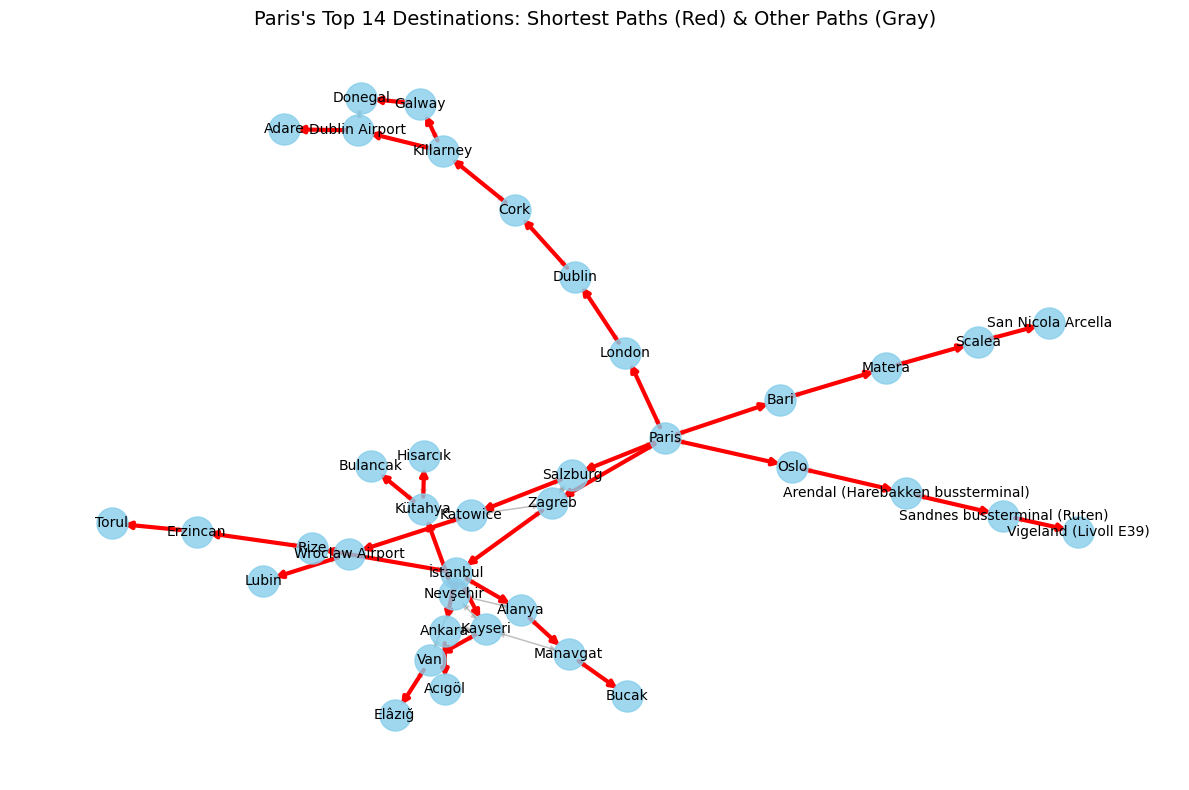

In [19]:
# Step 1: Compute shortest paths from one city to all cities
start_city = "Paris"
shortest_paths = {}
for city in G.nodes():
    if city != start_city:
        try:
            path = nx.shortest_path(G, source=start_city, target=city)
            shortest_paths[city] = path
        except nx.NetworkXNoPath:
            pass  # Ignore if no path exists

# Step 2: Sort paths by the number of transition nodes (longest first)
sorted_cities = sorted(shortest_paths.keys(), key=lambda c: len(shortest_paths[c]) - 2, reverse=True)

# Step 3: Select the top 14 cities with the most transition nodes
top_14_cities = sorted_cities[:14]

# Step 4: Collect nodes and edges for the filtered graph
filtered_nodes = set()
shortest_path_edges = set()
for city in top_14_cities:
    path = shortest_paths[city]
    filtered_nodes.update(path)
    shortest_path_edges.update((path[i], path[i + 1]) for i in range(len(path) - 1))

# Step 5: Create a subgraph containing ALL edges between selected nodes
filtered_G = G.subgraph(filtered_nodes)
all_edges = set(filtered_G.edges())  # Includes all possible paths
other_edges = all_edges - shortest_path_edges  # Get non-shortest path edges

# Step 6: Plot the network
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(filtered_G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(filtered_G, pos, node_size=500, node_color='skyblue', alpha=0.8)

# Draw ALL edges in gray (alternative paths)
nx.draw_networkx_edges(filtered_G, pos, edgelist=other_edges, width=1.0, alpha=0.3, edge_color='gray')

# Draw SHORTEST PATH edges in red
nx.draw_networkx_edges(filtered_G, pos, edgelist=shortest_path_edges, width=3, edge_color='red')

# Draw labels
nx.draw_networkx_labels(filtered_G, pos, font_size=10, font_color='black')

# Title and display
plt.title(f"{start_city}'s Top 14 Destinations: Shortest Paths (Red) & Other Paths (Gray)", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

## Visualizing In-Degree vs Out-Degree for the Top 50 Cities  
- **In-degree** and **out-degree** are computed for each city, representing the number of incoming and outgoing connections, respectively.  
- The data is sorted by **in-degree**, and the **top 50 cities** are selected for visualization.  
- A **stacked bar chart** is created to display the in-degree and out-degree for each city. The bars are colored **blue** for in-degree and **orange** for out-degree.  

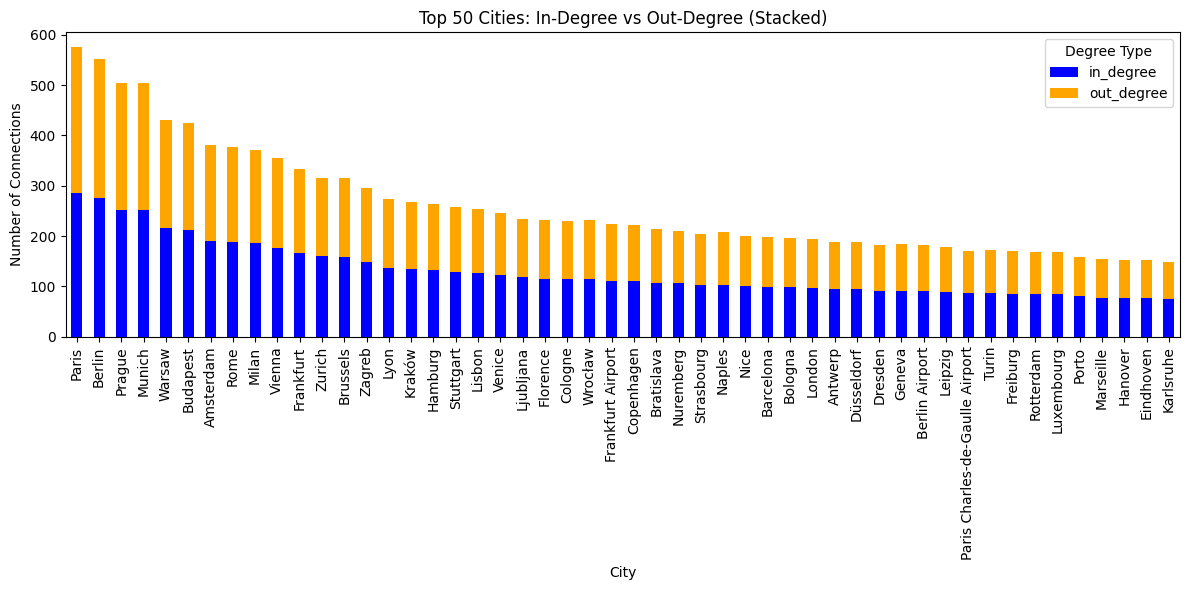

In [20]:
# Compute in-degree and out-degree
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# Create DataFrame
degree_comp = pd.DataFrame({
    'city': list(in_degree.keys()),
    'in_degree': list(in_degree.values()),
    'out_degree': list(out_degree.values())
})

# Sort by in-degree and select top 50 cities
degree_comp = degree_comp.sort_values('in_degree', ascending=False).head(50)

# Plot a stacked bar chart
degree_comp.set_index('city').plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'orange'])

# Formatting
plt.title('Top 50 Cities: In-Degree vs Out-Degree (Stacked)')
plt.ylabel('Number of Connections')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.legend(title='Degree Type')
plt.tight_layout()
plt.show()